# BEE 4750 Homework 2: Systems Modeling and Simulation

**Name**: Sarah Cooke, Laura Akey, Fabien DeSilva

**ID**: sec275, lka27, fmd48

> **Due Date**
>
> Thursday, 09/19/24, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to derive a model for water quality in a river
    system and use this model to check for regulatory compliance.
-   Problem 2 asks you to explore the dynamics and equilibrium stability
    of the shallow lake model under a particular set of parameter
    values.
-   Problem 3 (5750 only) asks you to modify the lake eutrophication
    example from Lecture 04 to account for atmospheric deposition.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/hw02`
   Installed Preferences ─────────────── v1.4.0
   Installed Xorg_xkbcomp_jll ────────── v1.4.2+4
   Installed Libmount_jll ────────────── v2.35.0+0
   Installed GR_jll ──────────────────── v0.72.7+0
   Installed JpegTurbo_jll ───────────── v2.1.91+0
   Installed LoggingExtras ───────────── v1.0.0
   Installed Accessors ───────────────── v0.1.37
   Installed RelocatableFolders ──────── v1.0.0
   Installed InlineStrings ───────────── v1.4.0
   Installed ConcurrentUtilities ─────── v2.2.0
   Installed Roots ───────────────────── v2.1.6
   Installed Formatting ──────────────── v0.4.2
   Installed Unitful ─────────────────── v1.14.0
   Installed Contour ─────────────────── v0.6.2
   Installed OpenSSL ─────────────────── v1.4.1
   Installed ColorSchemes ────────────── v3.21.0
   Installed PlotUtils ───────────────── v1.3.5
   Installed Xorg_libpthread_stubs_jll ─ v0.1.0+3
   Installed Cairo_jll ───────────────── v1.16.1+1
   Installed HTTP ──────────────────

In [2]:
using Plots
using LaTeXStrings
using CSV
using DataFrames
using Roots

## Problems (Total: 50/60 Points)

### Problem 1 (25 points)

A river which flows at 10 km/d is receiving discharges of wastewater
contaminated with CRUD from two sources which are 15 km apart, as shown
in the Figure below. CRUD decays exponentially in the river at a rate of
0.36 $\mathrm{d}^{-1}$.

<figure>
<img src="attachment:figures/river_diagram.png"
alt="Schematic of the river system in Problem 1" />
<figcaption aria-hidden="true">Schematic of the river system in Problem
1</figcaption>
</figure>

**In this problem**:

-   Assuming steady-state conditions, derive a model for the
    concentration of CRUD downriver by solving the appropriate
    differential equation(s) analytically.
-   Determine if the system in compliance with a regulatory limit of 2.5
    kg/(1000 m$^3$).

Point 1: point where the river meets the first input of wastewater
Point 2: point just before the river meets the second input of wastewater
Point 3: point once the river meets the second input of wastewater
Point C_final: after the second input meets the river

Concentration at Point 1 Calculations:
    Q_river x C_river + Q_input1 x C_input1 = C_point1 x (Q_river + Q_input1)
    C_point1 = (Q_river x C_river + Q_input1 x C_input1) / (Q_river + Q_point1)

Concentration at Point 3 Calculations:
    C_point3 = (Q_point2 x C_point2 + Q_input2 x C_input2) / (Q_point2 + Q_input2)

1st Order Decay Calculations:
    dC/dt = -kC
    1/C dC = -k dt
    ln(C) = -kt + C_0
    C = exp(-kt + C_0)
    C = C_0 x exp(-kt)


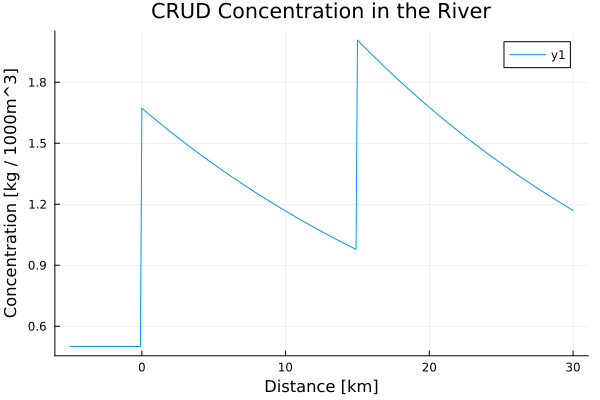

The maximum concentration in the river of CRUD: 2.0075225782896715


In [3]:
# Contaminated River

# solving C_point1 (where the river meets the first input of wastewater)
# C_point1 = (Q_river x C_river + Q_input1 x C_input1) / (Q_river + Q_point1)
Q_r = 250
C_r = 0.5
Q_input1 = 40
C_input1 = 9

C_point1 = (Q_r * C_r + Q_input1 * C_input1) / (Q_r + Q_input1)

#time between points 1 and 2
distance = 15 #km
velocity = 10 #km/d
t = distance / velocity
k = 0.36

# 1st order decay exact calculations
C_point2 = C_point1 * exp(-k * t)
Q_point2 = Q_r + Q_input1

# solving for C_3
Q_input2 = 60
C_input2 = 7
C_point3 = (Q_point2 * C_point2 + Q_input2 * C_input2) / (Q_point2 + Q_input2)


# Function for river concentration vs distance
function f(x)
    if x < 0
        return C_r
    elseif x < 15
        return C_point1 * exp(-k * (x / velocity))
    elseif x == 15
        return C_point3
    else
        return C_point3 * exp(-k * ((x-15) / velocity))
    end

end

# Create a range of x values
x = -5:0.1:30
# Calculate y values
y = f.(x)

# Plot the graph
p = plot(x, y, xlabel="Distance [km]", ylabel="Concentration [kg / 1000m^3]", title="CRUD Concentration in the River")
display(p)
println("The maximum concentration in the river of CRUD: ", C_point3)



This system does follow regulatory limits.

> **Tip**
>
> Formulate your model in terms of distance downriver, rather than
> leaving it in terms of time from discharge.

### Problem 2 (25 points)

Consider the shallow lake model from class:

$$
\begin{aligned}
X_{t+1} &= X_t + a_t + y_t + \frac{X_t^q}{1 + X_t^q} - bX_t, \\
y_t &\sim \text{LogNormal}(\mu, \sigma^2),
\end{aligned}
$$

where:

-   $X_t$ is the lake phosphorous (P) concentration at time $t$;
-   $a_t$ is the point-source P release at time $t$;
-   $y_t$ is the non-point-source P release at time $t$, which is
    treated as random from a LogNormal distribution with mean $\mu$ and
    standard deviation $\sigma$;
-   $b$ is the linear rate of P outflow;
-   $q$ is a parameter influencing the rate of P recycling from the
    sediment.

**In this problem**:

-   Make an initial conditions plot for the model dynamics for $b=0.5$,
    $q=1.5$, $y_t=0$, and $a_t=0$ for $t=0, \ldots, 30$. What are the
    equilibria? What can you say about the resilience of the system?

    > **Finding equilibria**
    >
    > Use [`Roots.jl`](https://juliamath.github.io/Roots.jl/stable/) to
    > find the equilibria by solving for values where $X_{t+1} = X_t$.
    > For example, if you have functions `X_outflow(X,b)` and
    > `X_recycling(X,q)`, you could create a function
    > `X_delta(x, a) = a + X_recycling(x) - X_outflow(x)` and call
    > `Roots.find_zero(x -> X_delta(x, a), x₀)`, where `x₀` is an
    > initial value for the search (you might need to use your plot to
    > find values for `x₀` near each of the “true” equilibria).

-   Repeat the analysis with $a_t=0.02$ for all $t$. What are the new
    equilibria? How have the dynamics and resilience of the system
    changed?

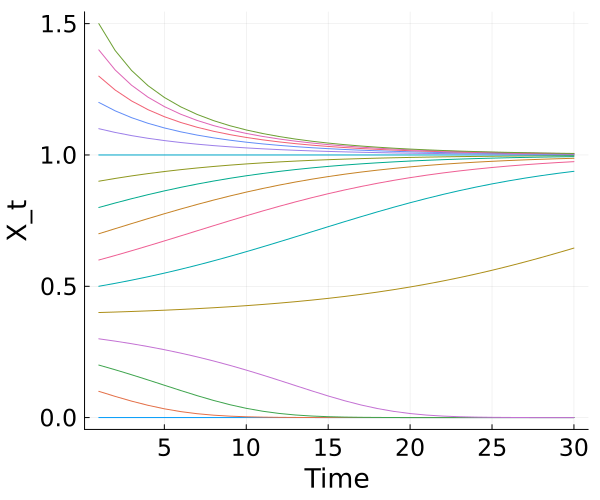

Equilibria: 0.0, 1.0


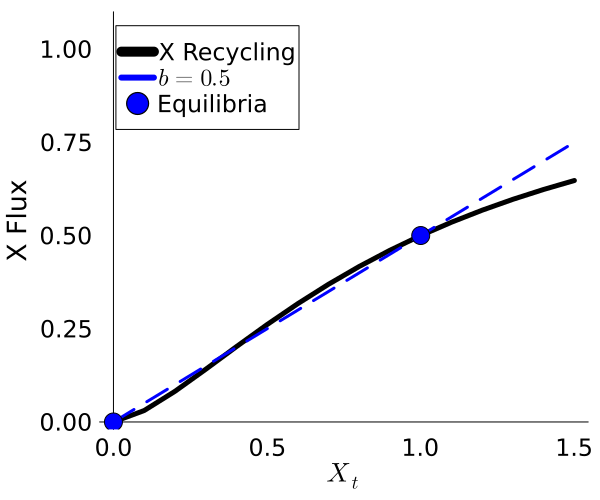

In [4]:
# #Shallow Lake Model for Part 1

# Define functions for lake recycling and outflows
X_recycling(x, q) = x.^q ./ (1 .+ x.^q)
X_outflow(x, b) = b .* x

#define constants and variables
T = 30
X_vals = collect(0.0:0.1:1.5)
b = 0.5
q = 1.5
a_t = zeros(T)
y_t = zeros(T)

# Simulation function
function simulate_lake_X(X_ic, T, b, q, a, y)
    X = zeros(T)
    X[1] = X_ic
    for t = 2:T
        X[t] = X[t-1] .+ a[t] .+ y[t] .+ X_recycling(X[t-1], q) .- X_outflow(X[t-1], b)
    end
    return X
end

# Generate data for each X_ic
X_data = map(x -> simulate_lake_X(x, T, b, q, a_t, y_t), X_vals)      

# Plot all time series
p = plot(ylabel="X_t", xlabel="Time", guidefontsize=18, tickfontsize=16, size=(600, 500))

# Loop through and plot each time series
for i in 1:length(X_vals)
    plot!(1:T, X_data[i], label=false)  # Add each line to the plot
end

display(p)  # Show the plot

#Finding equilibria

# Define the delta function (X_{t+1} - X_t)
X_delta(x, b, q) = X_recycling(x, q) - X_outflow(x, b)


# Find the equilibria using Roots.jl
equilibrium_1 = find_zero(x -> X_delta(x, b, q), 0.0)   # Guess near 0
equilibrium_2 = find_zero(x -> X_delta(x, b, q), 1.0)   # Guess near 1
println("Equilibria: ", equilibrium_1, ", ", equilibrium_2)

# plot recycling and outflows for selected values of b and q
p1 = plot(X_vals, X_recycling(X_vals, q), color=:black, linewidth=5,legend=:topleft, label="X Recycling", ylabel="X Flux", xlabel=L"$X_t$", tickfontsize=16, guidefontsize=18, legendfontsize=16, palette=:tol_muted, framestyle=:zerolines, grid=:false)
plot!(X_vals, X_outflow(X_vals, b), linewidth=3, linestyle=:dash, label=L"$b=0.5$", color=:blue)
# quiver!([0.1], [0.1], quiver=([1.3], [0.4]), color=:red, linewidth=2)
# quiver!([0.05], [0.2], quiver=([-0.125], [-0.05]), color=:red, linewidth=2)
# quiver!([1.0], [0.65], quiver=([-0.125], [-0.05]), color=:red, linewidth=2)
plot!(ylims=(-0.02, 1.1))
plot!(size=(600, 500))
eq1 = [0.0,1]
scatter!(p1, eq1, (y -> X_recycling(y, 2.5)).(eq1), label="Equilibria", markersize=10, markercolor=:blue)



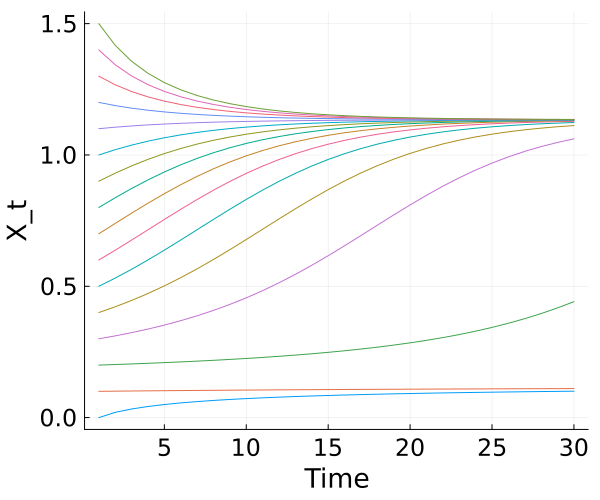

Equilibria: 0.1162444196607475, 1.1341008852434813


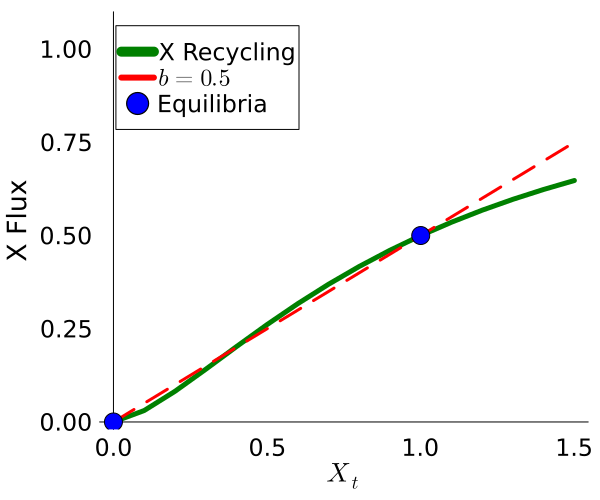

In [5]:
# #Shallow Lake Model Part 2

# Define functions for lake recycling and outflows
X_recycling(x, q) = x.^q ./ (1 .+ x.^q)
X_outflow(x, b) = b .* x

#define constants and variables
T = 30
X_vals = collect(0.0:0.1:1.5)
a_t = fill(0.02, T) # Define a_t as a constant value of 0.02 for all t
b = 0.5
q = 1.5
y_t = zeros(T)

# Simulation function
function simulate_lake_X(X_ic, T, b, q, a, y)
    X = zeros(T)
    X[1] = X_ic
    for t = 2:T
        X[t] = X[t-1] .+ a[t] .+ y[t] .+ X_recycling(X[t-1], q) .- X_outflow(X[t-1], b)
    end
    return X
end

# Generate data for each X_ic
X_data = map(x -> simulate_lake_X(x, T, b, q, a_t, y_t), X_vals)

# Plot all time series
p = plot(ylabel="X_t", xlabel="Time", guidefontsize=18, tickfontsize=16, size=(600, 500))

# Loop through and plot each time series
for i in 1:length(X_vals)
    plot!(1:T, X_data[i], label=false)  # Add each line to the plot
end

display(p)  # Show the plot
#Finding equilibria

# Define the delta function (X_{t+1} - X_t) for a constant a_t
X_deltaa(x, b, q, a_val) = a_val .+ X_recycling(x, q) .- X_outflow(x, b)


# Find the equilibria using Roots.jl
equilibrium_1a = find_zero(x -> X_deltaa(x, b, q, a_t), 0.0)   # Guess near 0
equilibrium_2a = find_zero(x -> X_deltaa(x, b, q, a_t), 1.0)   # Guess near 1
println("Equilibria: ", equilibrium_1a, ", ", equilibrium_2a)


# plot recycling and outflows for selected values of b and q
p1 = plot(X_vals, X_recycling(X_vals, 1.5), color=:green, linewidth=5,legend=:topleft, label="X Recycling", ylabel="X Flux", xlabel=L"$X_t$", tickfontsize=16, guidefontsize=18, legendfontsize=16, palette=:tol_muted, framestyle=:zerolines, grid=:false)
plot!(X_vals, X_outflow(X_vals, 0.5), linewidth=3, linestyle=:dash, label=L"$b=0.5$", color=:red)
plot!(ylims=(-0.02, 1.1),size=(600, 500))
eq1a = [0.0,1]
scatter!(p1, eq1a, (y -> X_recycling(y, 2.5)).(eq1), label="Equilibria", markersize=10, markercolor=:blue)

The equlibria for part 1 are 1.0 and 0.0. The system is resilient and is stable around these points as small pertubations reuslt in the same path as the equilibria.

For part 2 the equilibria are 0.1162 and 1.134. The higher equilibria, 1.134, is a stable point of equilibria where if there is a small perturbation in either direction, the X flux is likely to remain at the point of equilibria. The lower equilibria, 0.1162, is semi-stable, where in one direction (the negative direction) if there is a perturbation the flux is likely to remain at the point, but in the other, positive direction, a perturbation could send the flux to the higher equilibria point. 

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

Consider the lake eutrophication example from [Lecture
04](https://viveks.me/environmental-systems-analysis/slides/lecture03-1-eutrophication-modeling.html#/title-slide).
Suppose that phosphorous is also atmospherically deposited onto the lake
surface at a rate of
$1.6 \times 10^{-4} \mathrm{kg/(yr} \cdot \mathrm{m}^2)$, which is then
instantly mixed into the lake. Derive a model for the lake phosphorous
concentration and find the maximum allowable point source phosphorous
loading if the goal is to keep lake concentrations below 0.02 mg/L.

## References

List any external references consulted, including classmates.